In [24]:
import yaml
import glob
import datetime
import sys
import os

# Add the parent directory to the path so we can import the module
path_to_add = os.path.split(os.getcwd())[0]
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

import matplotlib as mpl
import  matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import numpy as np
import networkx as nx

import src.hardwareModel as hardwareModel
from src.sim_util import get_latest_log_dir
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
sns.set_theme(
    context="paper", style="white", palette="bright", rc={"figure.figsize": (5, 4)}
)
plt.rcParams["figure.dpi"] = 192
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

In [26]:
rng = np.random.default_rng(0)

In [27]:
def parse_log_file(log_file):
    forward_edp = []
    inverse_edp = []
    with open(log_file, "r") as f:
        lines = f.readlines()
    for line in lines:
        if "Forward EDP" in line:
            forward_edp.append(float(line.split(":")[-1].strip()))
        if "Inverse EDP" in line:
            inverse_edp.append(float(line.split(":")[-1].strip()))
    return len(forward_edp), forward_edp, inverse_edp

In [28]:
year = 2024
month = 6
day = 20
hour = 15
minute = 55
sec = 49
log_dir = f"logs/{year}-{month:02}-{day:02}_{hour:02}-{minute:02}-{sec:02}"

log_dir = get_latest_log_dir()

print(log_dir)

num_iters, forward_edp, inverse_edp = parse_log_file(f"{log_dir}/results.txt")

edps = [val for pair in zip(forward_edp, inverse_edp) for val in pair]

/Users/vbalanaga/Documents/RSG/codesign/logs/2024-11-18_10-02-55


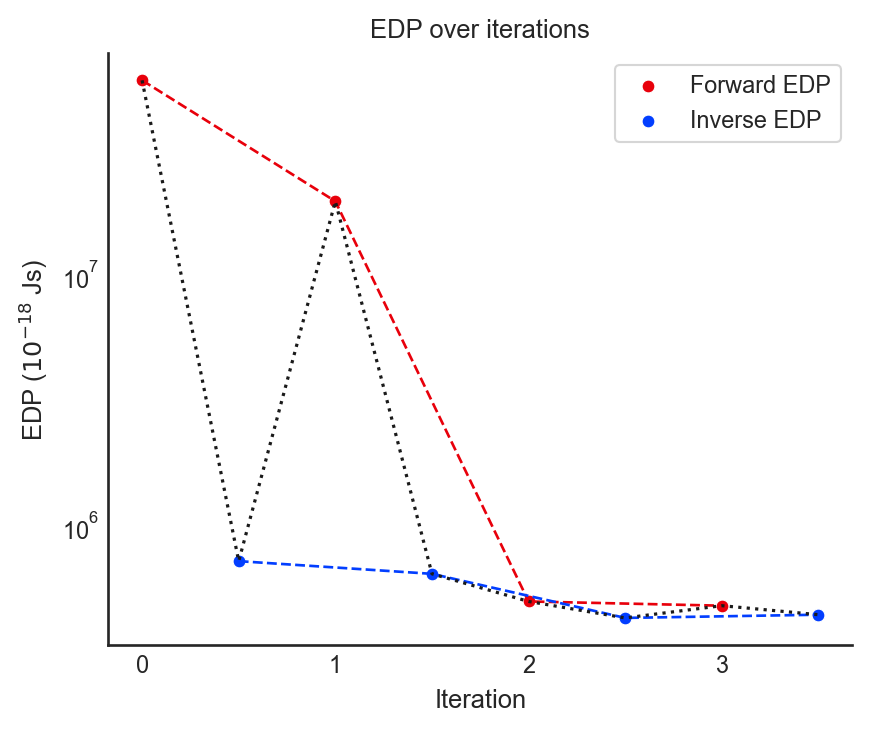

In [29]:
plt.title("EDP over iterations")
c = sns.scatterplot(x=range(num_iters), y=forward_edp, label="Forward EDP", c="r")
sns.lineplot(x=range(num_iters), y=forward_edp, linestyle="dashed", linewidth=1, c="r")
c = sns.scatterplot(
    x=np.arange(0.5, num_iters + 0.5), y=inverse_edp, label="Inverse EDP", c="b"
)
sns.lineplot(
    x=np.arange(0.5, num_iters + 0.5),
    y=inverse_edp,
    linestyle="dashed",
    linewidth=1,
    c="b",
)
sns.lineplot(x=np.arange(0, num_iters, 0.5), y=edps, linestyle="dotted", c="k")

sns.despine()

plt.xticks(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel(r"EDP ($10^{-18}$ Js)")
plt.legend()
plt.yscale("log")
plt.savefig(f"{log_dir}/edp_over_iterations.png")
plt.show()

In [30]:
rcs = []
for i in range(num_iters):
    rcs.append(yaml.load(open(f"{log_dir}/rcs_{i}.yaml", "r"), Loader=yaml.Loader))

In [31]:
# remove all parameters in rcs that didn't change
keys = list(rcs[0]["Ceff"].keys())

for k in keys:
    val = rcs[0]["Ceff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Ceff"][k]
        to_pop &= v == val
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Ceff"].pop(k)

    val = rcs[0]["Reff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Reff"][k]
        to_pop &= v == val
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Reff"].pop(k)
print(rcs)

[{'Cacti': {'C_fringe': 9.834614763250224e-17, 'C_g_ideal': 5.395185556847238e-16, 'C_junc': 7.880017461720891e-10, 'C_junc_sw': 4.0814131279318383e-16, 'C_ox': 5.0390827529804976e-14, 'I_g_on_n': 1.81e-09, 'I_off_n': 4.223982176555892e-07, 'I_on_n': 0.0023189825562730344, 'I_on_p': 0.0013132, 'Mobility_n': 42580367628.492775, 'Vdd': 0.785252193350358, 'Vdsat': 0.02225363329285585, 'Vth': 0.13639171570921463, 'Wmemcella': 1.0844730798636382, 'Wmemcellnmos': 2.078994854884133, 'Wmemcellpmos': 1.1980648685684137, 'alpha_scatter': 1.0, 'area_cell': 145.88806291220834, 'asp_ratio_cell': 1.4406746843082952, 'aspect_ratio': 2.981590164935177, 'barrier_thickness': 1e-09, 'chip_layout_overhead': 1.2, 'core_tx_density': 2.55102, 'dishing_thickness': 1e-09, 'dram_cell_C': 1e-09, 'dram_cell_I_off_worst_case_len_temp': 1e-09, 'dram_cell_I_on': 1e-09, 'dram_cell_Vdd': 1e-09, 'fringe_cap': 3.3231797439000173e-16, 'gmp_to_gmn_multiplier': 1.3578306774171247, 'horiz_dielectric_constant': 1.39014539906

In [32]:
rc_df = pd.DataFrame(rcs)
print(rc_df.columns)

Index(['Cacti', 'Cacti_IO', 'Ceff', 'Reff', 'other'], dtype='object')


In [33]:
def plot_from_rcs(k1, k2s, num_iters, rcs, title="", ylabel="", labels=[]):
    if type(k2s) is not list:
        k2s = [k2s]
    for i in range(len(k2s)):
        k2 = k2s[i]

        val = np.asarray(list(map(lambda x: float(x[k1][k2]), rcs)))
        # name = f"{k1}_{k2}" if k1 != "other" else k2
        val = val / val[0]
        if len(labels) != 0:
            lbl = labels[i]
        else:
            lbl = k2
        c = sns.scatterplot(x=range(num_iters), y=val, label=lbl)
        sns.lineplot(
            x=range(num_iters), y=val, linestyle="dotted", markers=True
        )  # c= c.get_facecolor())
    if title == "":
        title = f"{k1} over iterations"
    else:
        title += " over iterations"
    plt.title(title)
    sns.despine()

    # for i in range(num_iters):
    #     plt.scatter(rcs[i][k1], rcs[i][k2], label=f"iter {i}")
    plt.xlabel("Iteration")
    if ylabel == "":
        ylabel = f"{k1} (normalized)"
    else:
        ylabel += " (normalized)"
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(f"{log_dir}/{'_'.join(title.split(' '))}.png")
    plt.show()

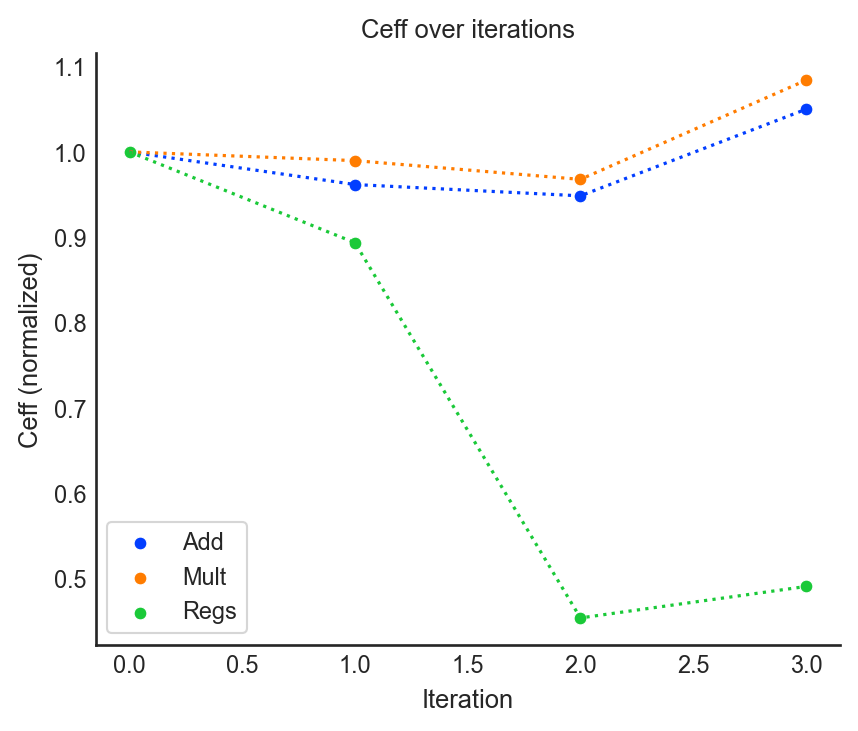

In [34]:
k1 = "Ceff"
k2s = list(rcs[0][k1].keys())

plot_from_rcs(k1, k2s, num_iters, rcs)

/var/folders/pb/xkf_1m6d4_b_x6511mct3t3r0000gn/T/ipykernel_87436/25122611.py:7: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


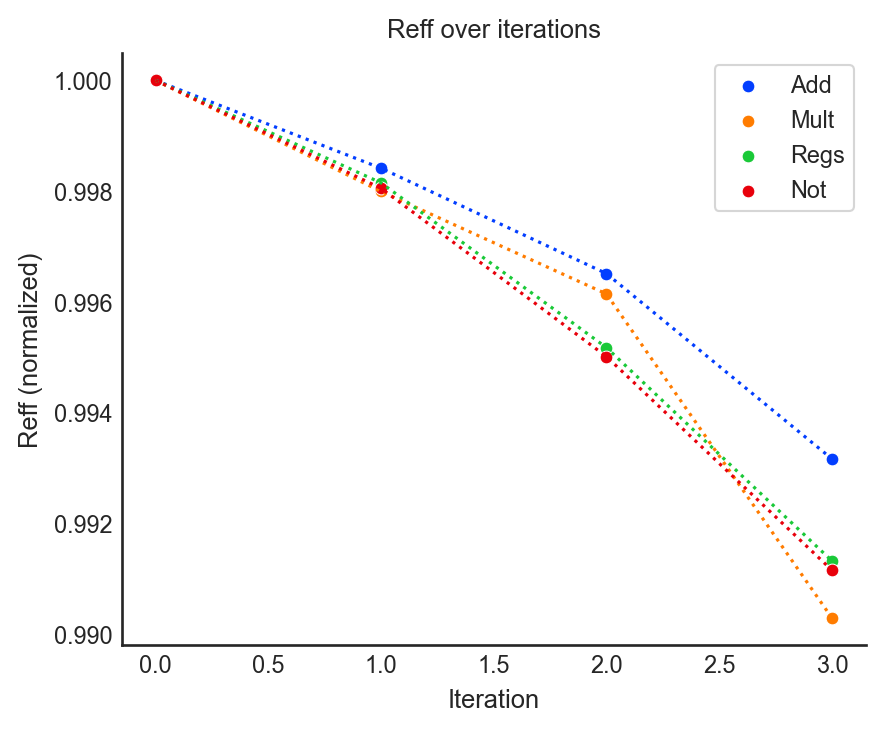

In [35]:
k1 = "Reff"
k2s = list(rcs[0][k1].keys())
tmp_idx = k2s.index("Not")
k2s.pop(tmp_idx)
k2s.append("Not")

with pd.option_context("mode.use_inf_as_na", True):
    plot_from_rcs(k1, k2s, num_iters, rcs)

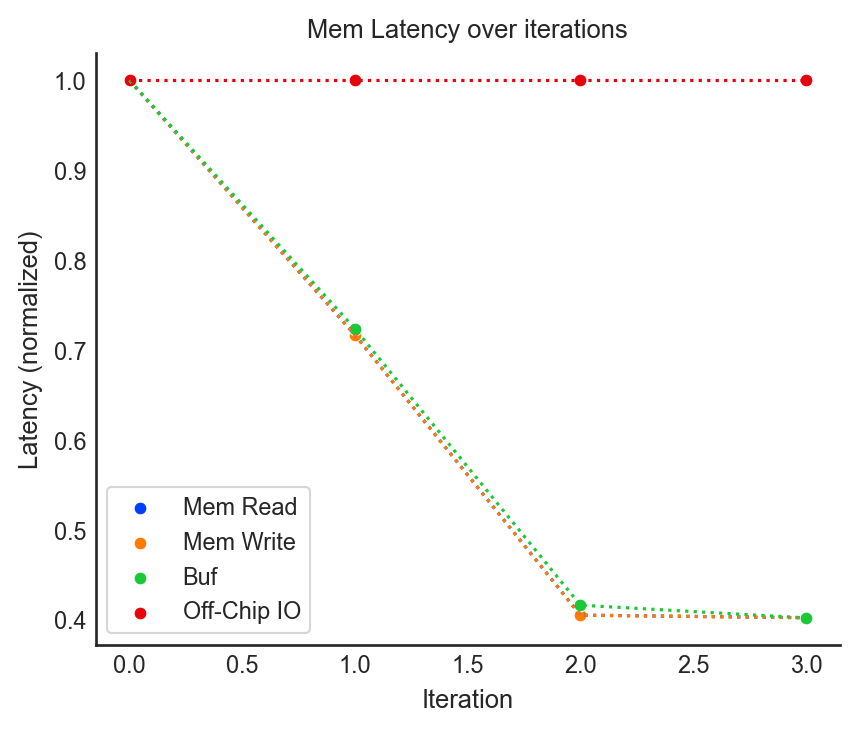

In [36]:
k1 = "other"
k2s = ["MemReadL", "MemWriteL", "BufL", "OffChipIOL"]
labels = ["Mem Read", "Mem Write", "Buf", "Off-Chip IO"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Latency", "Latency", labels)

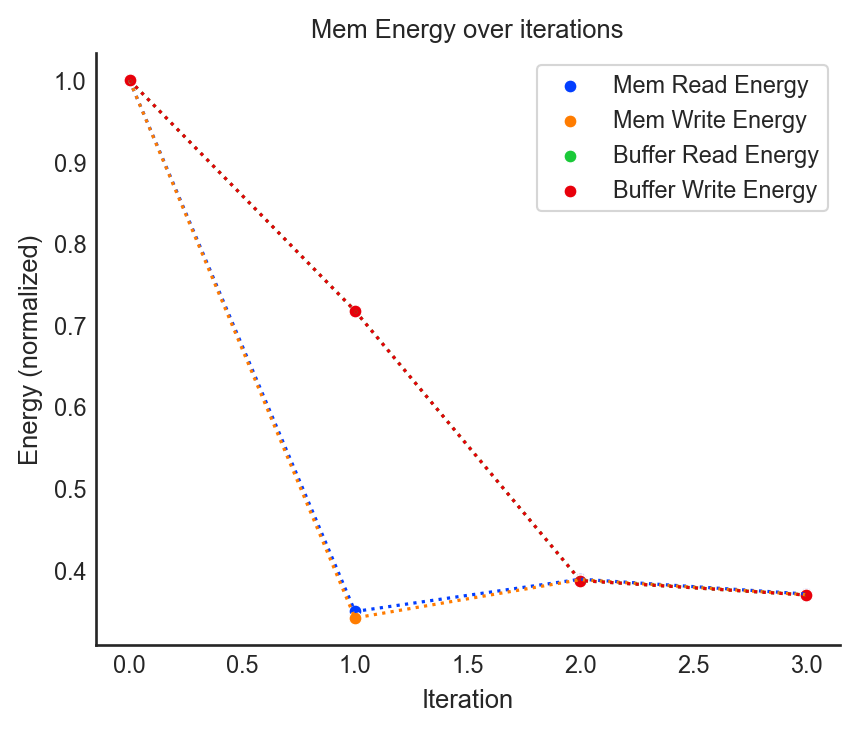

In [37]:
k1 = "other"
k2s = ["MemReadEact", "MemWriteEact", "BufReadEact", "BufWriteEact"]  # "MemPpass"]
labels = [
    "Mem Read Energy",
    "Mem Write Energy",
    "Buffer Read Energy",
    "Buffer Write Energy",
]  # "Passive"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Energy", "Energy", labels)

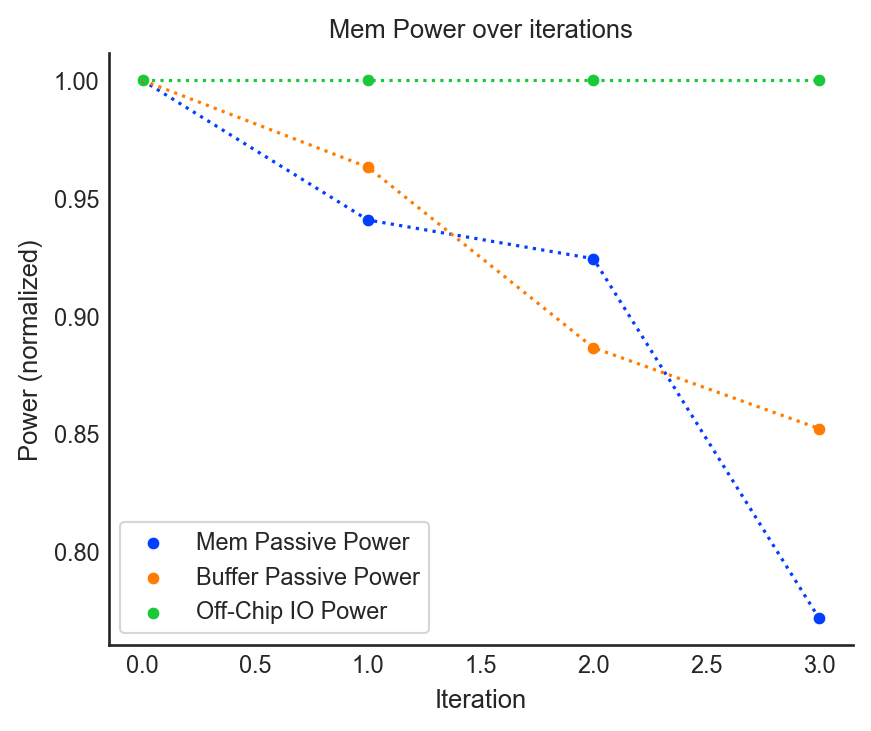

In [38]:
k1 = "other"
k2s = ["MemPpass", "BufPpass", "OffChipIOPact"]
labels = ["Mem Passive Power", "Buffer Passive Power", "Off-Chip IO Power"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Power", "Power", labels)

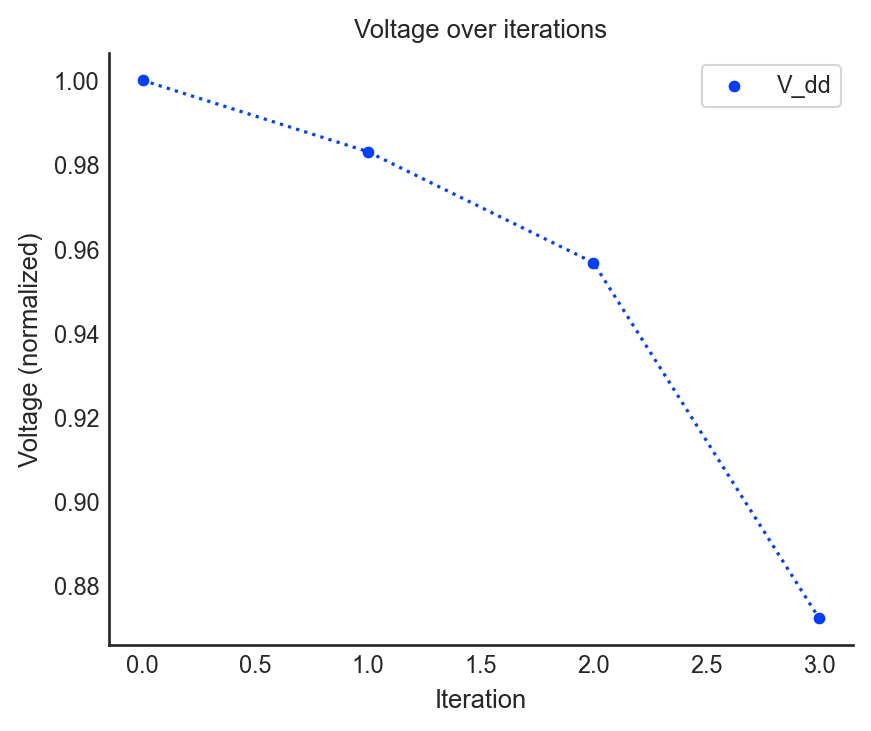

In [39]:
k1 = "other"
k2s = ["V_dd"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Voltage", "Voltage")

#### Area

#### Get stalled node statistics

In [40]:
# Specify the directory path and the file format
file_format = 'schedule_*.gml'  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + '/' + file_format))
schedule_node_counts = pd.DataFrame()
print(files)
# Print the list of files
for file in files:
    g = nx.read_gml(file)
    func_counts = hardwareModel.get_func_count(g)
    stall_nodes = hardwareModel.get_nodes_with_func(g, "stall")
    stall_funcs, counts = np.unique(list(map(lambda x: "stall_" + x.split("_")[3], stall_nodes.keys())), return_counts = True)
    assert func_counts["stall"] == counts.sum()
    stall_counts = dict(zip(stall_funcs, counts))
    dict_counts = {**func_counts, **stall_counts}
    schedule_node_counts = pd.concat(
        [schedule_node_counts, pd.DataFrame([dict_counts])], ignore_index=True
    )

print(schedule_node_counts)

['/Users/vbalanaga/Documents/RSG/codesign/logs/2024-11-18_10-02-55/schedule_0.gml', '/Users/vbalanaga/Documents/RSG/codesign/logs/2024-11-18_10-02-55/schedule_1.gml', '/Users/vbalanaga/Documents/RSG/codesign/logs/2024-11-18_10-02-55/schedule_2.gml', '/Users/vbalanaga/Documents/RSG/codesign/logs/2024-11-18_10-02-55/schedule_3.gml']
   Add  stall  Regs  Buf  MainMem  end  Mult  stall_Add  stall_Buf  \
0   12    602    44   44       44    1     8         20      484.0   
1   12    602    44   44       44    1     8         20        NaN   
2   12    118    44   44       44    1     8         20        NaN   
3   12    118    44   44       44    1     8         20        NaN   

   stall_Regs  stall_MainMem  
0          98            NaN  
1          98          484.0  
2          98            NaN  
3          98            NaN  


['stall_Add', 'stall_Buf', 'stall_Regs', 'stall_MainMem']


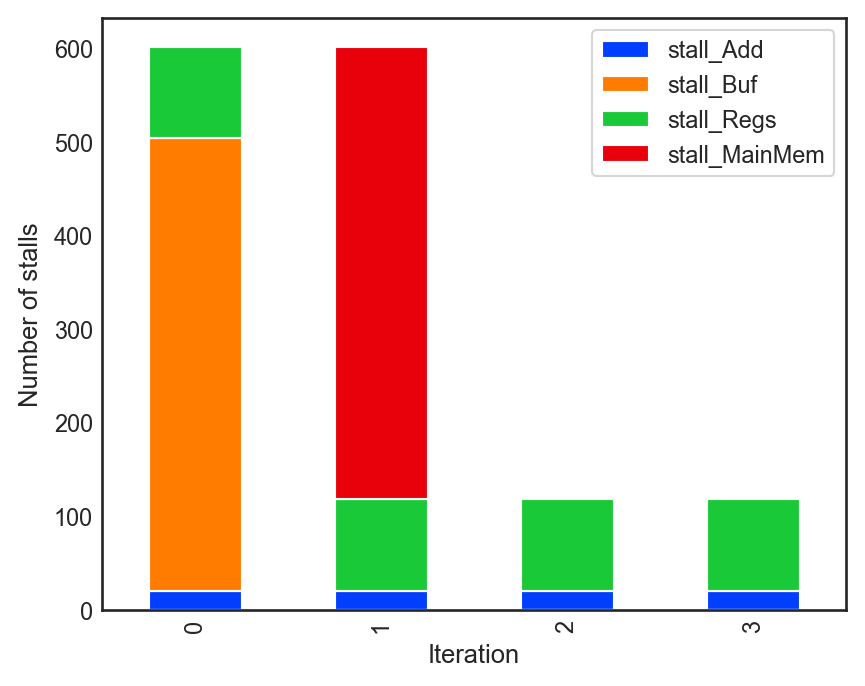

In [41]:
stall_columns = list(filter(lambda x: "stall_" in x, list(schedule_node_counts.columns)))
print(stall_columns)
schedule_node_counts[stall_columns].plot(kind="bar", stacked=True)
plt.xlabel("Iteration")
plt.ylabel("Number of stalls")
plt.savefig(f"{log_dir}/stalls_over_iterations.png")

#### Architecture Change Statistics

In [42]:
file_format = "netlist_*.gml"  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + "/" + file_format))
netlist_function_counts = pd.DataFrame()

# Print the list of files
for file in files:
    g = nx.read_gml(file)
    func_counts = hardwareModel.get_func_count(g)
    netlist_function_counts = pd.concat(
        [netlist_function_counts, pd.DataFrame([func_counts])], ignore_index=True
    )

print(netlist_function_counts)

   Add  Regs  Buf  MainMem  Mult
0    1     2    1        1     1
1    1     2    2        1     1
2    1     2    2        2     1
3    1     2    2        2     1


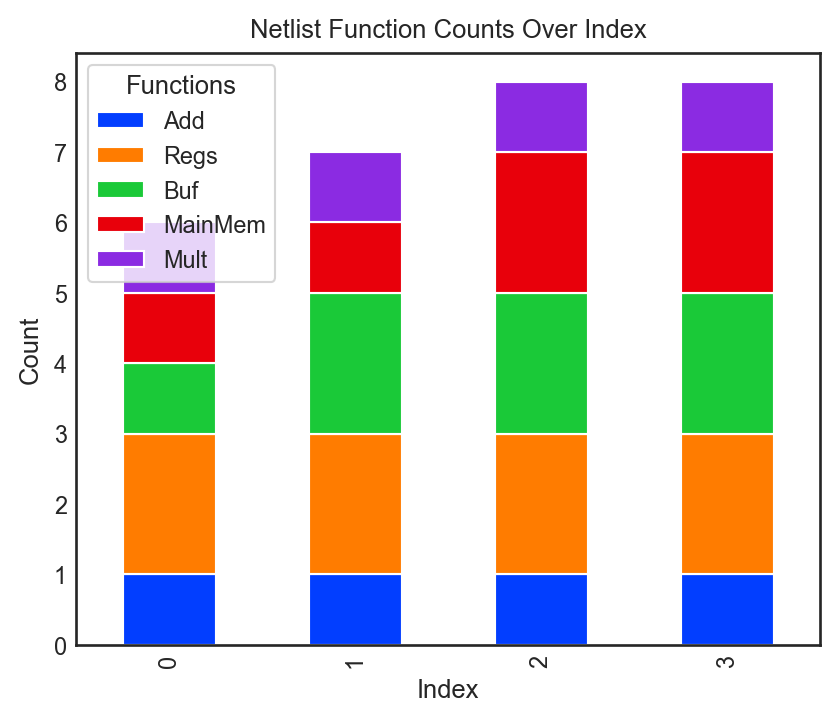

In [43]:
netlist_function_counts.plot(kind='bar', stacked=True)
plt.xlabel("Index")
plt.ylabel("Count")
plt.title("Netlist Function Counts Over Index")
plt.legend(title="Functions")
plt.savefig(f"{log_dir}/netlist_function_counts.png")
plt.show()

#### Tech params

In [44]:
file_format = "tech_params*.yaml"  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + "/" + file_format))
tech_params_df = pd.DataFrame()


def convert_tech_params_to_df(tech_params: dict, t: int) -> pd.DataFrame:
    """
    Returns a DF with index operator and iteration step.
    """
   
    area= []
    dynamic_power= []
    leakage_power= []
    dynamic_energy= []
    latency=[]
    operator= []
    T= []
     
    for key in tech_params["area"].keys():
        area.append(tech_params["area"][key])
        dynamic_power.append(tech_params["dynamic_power"][key] if key in tech_params["dynamic_power"] else np.nan)
        leakage_power.append(tech_params["leakage_power"][key] if key in tech_params["leakage_power"] else np.nan)
        dynamic_energy.append(tech_params["dynamic_energy"][key] if key in tech_params["dynamic_energy"] else np.nan)
        latency.append(tech_params["latency"][key] if key in tech_params["latency"] else np.nan)
        operator.append(key)
        T.append(t)
      

    for key in tech_params["dynamic_energy"].keys():
        for k2 in tech_params["dynamic_energy"][key].keys():
            area.append(np.nan)
            dynamic_power.append(np.nan)
            leakage_power.append(np.nan)
            dynamic_energy.append(tech_params["dynamic_energy"][key][k2] if k2 in tech_params["dynamic_energy"][key] else np.nan)
            latency.append(np.nan)
            operator.append(key + "_" + k2)
            T.append(t)

    ind = pd.MultiIndex.from_arrays([T, operator], names=("T", "Operator"))
    df = pd.DataFrame(
        {
            "Area": area,
            "Dynamic Power": dynamic_power,
            "Leakage Power": leakage_power,
            "Dynamic Energy": dynamic_energy,
            "Latency": latency,
        },
        index=ind,
    )                   
    return df


# Print the list of files
for t, file in enumerate(files):
    tp = yaml.load(open(file, "r"), Loader=yaml.Loader)
    tp_df = convert_tech_params_to_df(tp, t)
    tech_params_df = pd.concat([tech_params_df, tp_df])


print(tech_params_df)

                       Area  Dynamic Power  Leakage Power Dynamic Energy  \
T Operator                                                                 
0 Add             91.811174      27.964575    1679.676089            NaN   
  And            149.057647      45.972642    2440.779317            NaN   
  BitAnd          43.961702      13.558752     719.861181            NaN   
  BitOr           35.887104      12.767525     719.861181            NaN   
  BitXor          47.849472      14.385943     959.814908            NaN   
...                     ...            ...            ...            ...   
3 USub            91.811174      24.331046    1473.855646            NaN   
  Buf_Read              NaN            NaN            NaN       0.258363   
  Buf_Write             NaN            NaN            NaN       0.262779   
  MainMem_Read          NaN            NaN            NaN       0.070624   
  MainMem_Write         NaN            NaN            NaN       0.113127   

           

lt operators: ['And', 'BitXor', 'Buf', 'FloorDiv', 'GtE', 'LShift', 'Lt', 'MainMem', 'Mult', 'NotEq', 'Sub', 'USub']
gt operators: ['BitAnd', 'Eq', 'Gt', 'Invert', 'LtE', 'Mod', 'Not', 'RShift', 'Regs', 'UAdd']
eq operators: ['BitOr', 'IsNot']


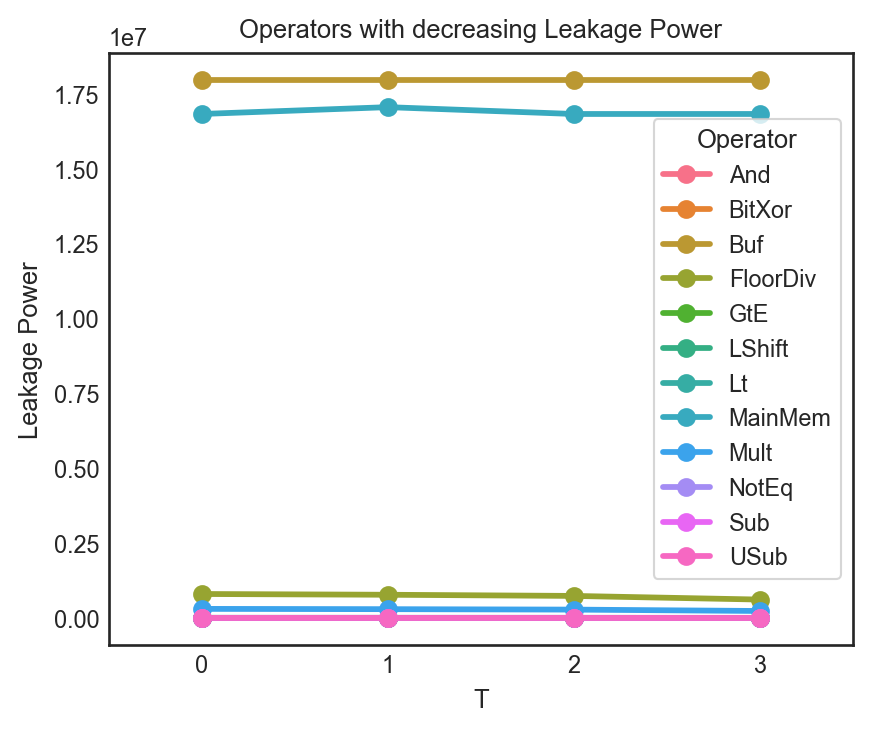

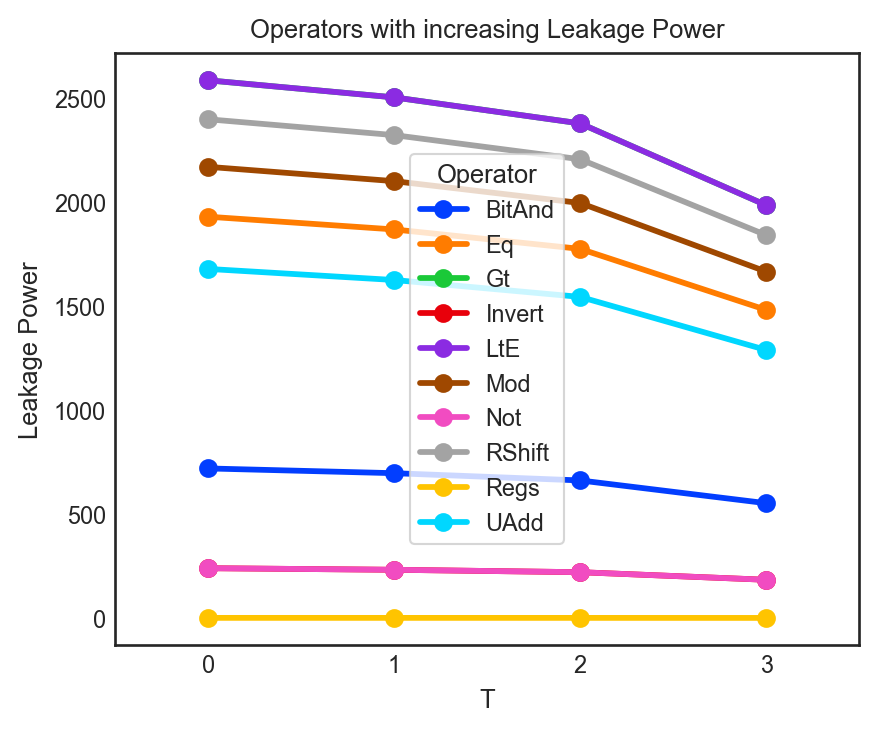

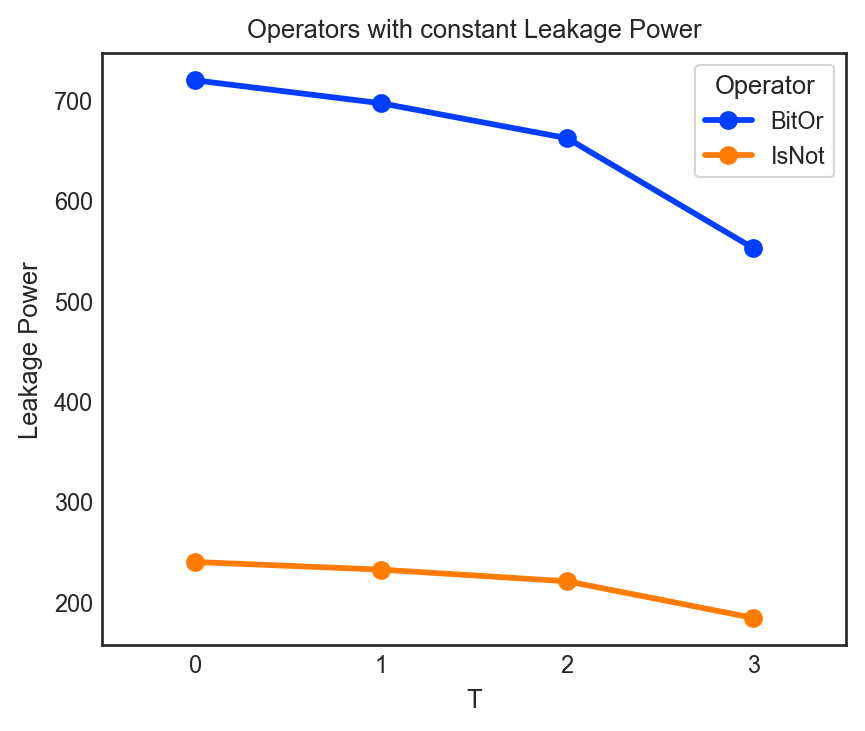

In [45]:
lt_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] > tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"lt operators: {lt_operators}")
gt_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] < tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"gt operators: {gt_operators}")
eq_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] == tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"eq operators: {eq_operators}")

# operators = ['OffChipIO', "MainMem", "Buf", "Regs"]
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(lt_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with decreasing Leakage Power")
plt.show()
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(gt_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with increasing Leakage Power")
plt.show()
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(eq_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with constant Leakage Power")
plt.show()

In [46]:
tech_params_df[tech_params_df.index.get_level_values("Operator") == "FloorDiv"]["Latency"]

T  Operator
0  FloorDiv    6.9482
1  FloorDiv    6.9482
2  FloorDiv    6.9482
3  FloorDiv    6.9482
Name: Latency, dtype: float64